![](https://images.pexels.com/photos/33684/astronaut-spacewalk-iss-tools.jpg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Orbit Simulation

This is a trivial simulation of orbital dynamics.

## Conventions

- R: vector R having x,y,z components
- r: scalar magnitude of R: $r = \sqrt{x^2 + y^2 + z^2}$

## Energy

Total mechanical energy is the sum of kinetic energy (KE) and potential energy (PE):

$$
E = KE + PE = \frac{1}{2}mV^2 + \frac{m\mu}{r}
$$

The angular momentum (without any pertibations like drag) is constant.

$$
H = R \times V
$$

## Two Body Motion and Peritibation

$$
\ddot R + \frac{\mu}{r^3}R = a_D
$$

where $a_D$ are forces that pertibate the orbit like drag. A simple model for drag is:

$$
a_D = -\frac{1}{2} \rho v^2 \frac{c_D a}{m}i_v
$$

where $\rho$ is the atmosphere density, $v$ is the scalar velocity of the satellite in the direction of travel, $A$ is the effective (projected) area of the satellite, $m$ is the satellite mass, and $i_v$ is the unit vector of the satelite velocity.

The term $\frac{m}{c_D a}$ is also known as the balistic coefficient (BC).

$$
a_D = -\frac{1}{2} \frac{\rho v^2}{BC}i_v
$$

- **High BC:** little atomopheric drag and longer life in low orbit. Vehicle re-entry is fast with high velocity impact (good for making big holes in the ground). This is easily seen in the equation above; as the demoninator becomes larger, the term $a_D$ becomes smaller
- **Low BC:** higher drag and reduced life-time for low orbiting satellites that cannot perform orbital maintenance maneuvers to boost themselves higher. Vehicles re-entering will hit subsonic speeds before the reaching ground and this is typical of vehicles carrying humans back from space.

### Others

- $J_2$ are the second harmonic and the effects are due to the oblatness of the Earth. This results in a percession of RAAN ($\Omega$) and argument of perigee ($\omega$).
- $J_3$ effects the third homonic and affect the inclination and the eccentricity of the orbit

# References

- Wikipedia: [Ballistic coefficients](https://en.wikipedia.org/wiki/Ballistic_coefficient)
- Wikipedia: [Kepler Orbit](https://en.wikipedia.org/wiki/Kepler_orbit)
- Wikipedia: [Pertibation (astronomy)](https://en.wikipedia.org/wiki/Perturbation_(astronomy)#Perturbation_of_the_orbital_plane_2)
- Useful [formulas](https://elainecoe.github.io/orbital-mechanics-calculator/formulas.html) for orbits and astrodynamics
- Vladimir Chobotov, "Orbital Mechanices 3rd Ed"
    - $J_2$ effects, pg 215
    - $J_3$ effects, pg 220

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
from numpy import pi, sqrt, sin, cos
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import time
from pyrk import RK4

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [3]:
from doop.constants import Earth
from doop import COE

In [4]:
def twobody(t,X,u,params=None):
    """
    X=[R,V]
    """
    R = X[:3]
    r = np.linalg.norm(R)
    mu = Earth.mu #km^3/sec^2
    
    dx = np.zeros(6)
    dx[:3] = X[3:6]       # Rdot = V
    dx[3:] = -mu*R/(r**3) # Vdot = accelerations/forces
    
    return dx

In [5]:
def twobody_drag(t,X,u,params=None):
    """
    X=[R,V]
    """
    R = X[:3]
    r = np.linalg.norm(R)
    mu = Earth.mu #km^3/sec^2
    
    v = np.linalg.norm(X[3:6])
    i = X[3:6]/v
    A = 10e-6  # km^2
    m = 500 # kg
    rho = 4e-4 # kb/km^3
    cd = 1
    D = -1/2*rho*v**2*(cd*A)/m*i
    
    dx = np.zeros(6)
    dx[:3] = X[3:6]         # Rdot = V
    dx[3:] = -mu*R/(r**3)-D # Vdot = accelerations/forces
    
    return dx

In [25]:
coe = COE(7000, 0.01, 0, 0, 0,0)
rr = coe.r
vv = coe.velocity
print(f">> COE R: {rr:.1f} km   Vel: {vv:.1f} km/sec   Altitude: {rr-Earth.radius:.1f} km")

# r,v = coe2rv(*coe)
r,v = coe.to_rv()
print(f">> Pos[km]: {r}   Vel[km/s]: {v}")
x0 = np.hstack((r,v))

>> COE R: 6930.0 km   Vel: 7.6 km/sec   Altitude: 551.6 km
>> Pos[km]: [6930.    0.    0.]   Vel[km/s]: [0.    7.622 0.   ]


In [30]:
rk = RK4(twobody)

dt = 1
tx = 0

t = []
y = []

# orbital period
T = coe.period
print(f">> Period of orbit: {T:.1f} sec or {T/60:.1f} mins")

x = x0
for i in range(int(T//dt)):
    x = rk.step(x,None,tx, dt)
    
    y.append(x)
    t.append(tx/60)
    
    tx += dt

>> Period of orbit: 5828.5 sec or 97.1 mins


<IPython.core.display.Javascript object>


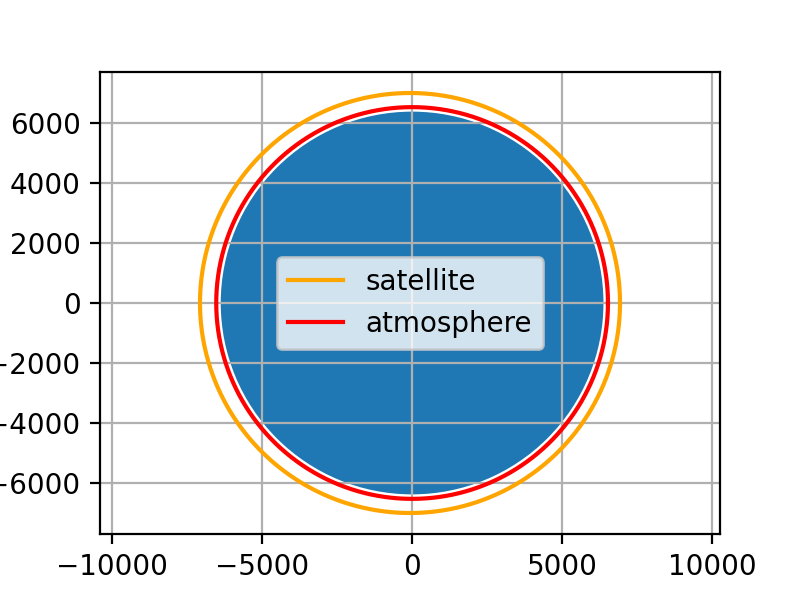

In [31]:
plt.figure(figsize=(4,3))
ax = plt.gca()

# plot orbit
ax.plot(
    [x[0] for x in y],
    [x[1] for x in y],
    color="orange",
    label="satellite"
)

# plot atmosphere
atmos = Earth.radius+150
ax.plot(
    atmos*np.cos(np.array(range(361))*np.pi/180), 
    atmos*np.sin(np.array(range(361))*np.pi/180),
    color="red",
    label="atmosphere"
)

earth = Circle(xy=(0,0), radius=Earth.radius)
ax.add_patch(earth)
ax.axis("equal")
ax.grid(True)
ax.legend();

<IPython.core.display.Javascript object>


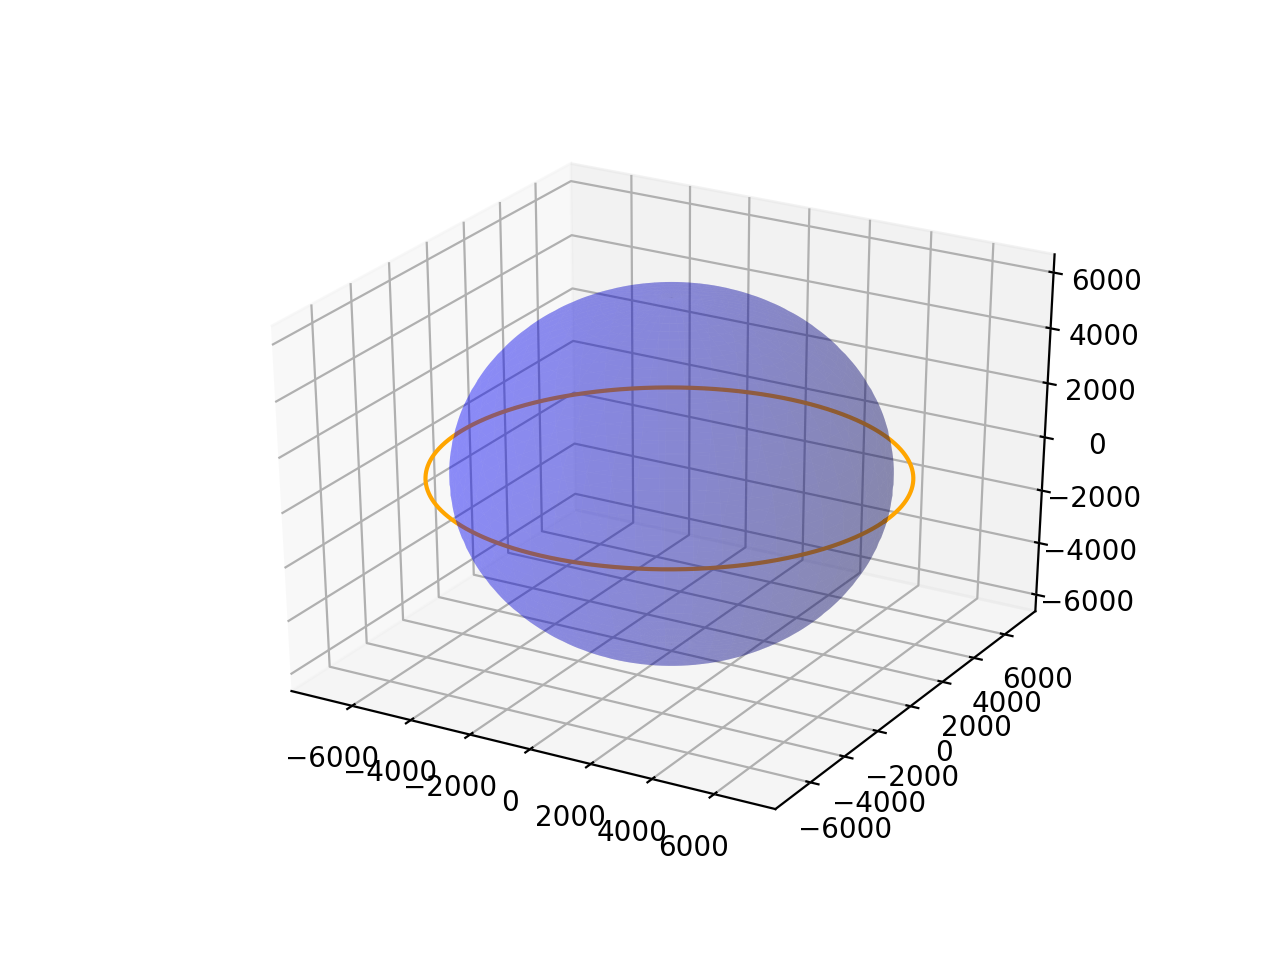

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    [x[0] for x in y],
    [x[1] for x in y],
    [x[2] for x in y],
    color="orange",
    label="satellite"
)

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ex = Earth.radius * np.outer(np.cos(u), np.sin(v))
ey = Earth.radius * np.outer(np.sin(u), np.sin(v))
ez = Earth.radius * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(ex, ey, ez, color='b', alpha=0.25)

# ax.axis("equal")
ax.grid(True);